In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import torch
from sklearn.metrics import mean_squared_error

In [43]:
def build_group(df, n=1000, center=(1.0,2.0)):
    for _ in range(n):
        noise1 = pyro.sample('A', dist.Normal(torch.tensor(0.0),0.2))
        noise2 = pyro.sample('A', dist.Normal(torch.tensor(0.0),0.2))
        noise3 = pyro.sample('A', dist.Normal(torch.tensor(0.0),0.2))
        A = pyro.sample('A', dist.Normal(torch.tensor(center[0]), 1))
        B = pyro.sample('B', dist.Normal(torch.tensor(center[1]), 1))
        C = pyro.sample('T', dist.Normal(A+B, 2))
        A = A + noise1
        B = B + noise2
        C = C + noise3
        df = df.append({
            'A': A.item(),
            'B': B.item(),
            'C': C.item(),
        }, ignore_index=True)
    return df

df_synth_male = pd.DataFrame({}, columns=['A','B','C'])
df_synth_male = build_group(df_synth_male)
df_synth_female = pd.DataFrame({}, columns=['A','B','C'])
df_synth_female = build_group(df_synth_female, center=(-1.0,-2.0))
df_synth_male['M'] = 1
df_synth_female['M'] = 0
df_synth_male['F'] = 0
df_synth_female['F'] = 1
df_synth = pd.concat([df_synth_female,df_synth_male], ignore_index=True)
df_synth = df_synth.sample(frac=1)
df_synth

,A,B,C,M,F
1859,0.842885,1.931011,1.802244,1,0
699,-0.817515,-0.444602,-1.170666,0,1
2,0.945165,0.210855,4.119102,0,1
50,-1.206416,-1.720255,-3.461591,0,1
242,-0.793993,-2.274374,1.963411,0,1
...,...,...,...,...,...
1397,1.571735,0.781037,3.280340,1,0
1124,0.238650,3.289440,5.955738,1,0
1362,1.750827,2.463276,1.034175,1,0
1795,1.120181,0.687633,1.218122,1,0


In [44]:
features = list(df_synth.columns)
# features.remove('F')
target = 'C'
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_synth[features], df_synth[target], test_size=0.2, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)
y_pred = reg.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
pd.DataFrame({'pred': y_pred, 'test': y_test})

6.0264226168829796e-15


,pred,test
1363,0.244967,0.244967
334,-2.737871,-2.737871
1047,4.964841,4.964841
1258,-0.317011,-0.317011
130,-5.167820,-5.167820
...,...,...
929,-0.967687,-0.967687
1270,5.099952,5.099952
654,-2.611486,-2.611486
1584,1.757915,1.757915


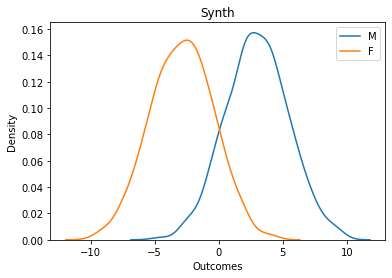

In [45]:
groups = ['M', 'F']
fig, ax = plt.subplots()
for j in range(len(groups)):
    group = groups[j]
    sns.kdeplot(df_synth[df_synth[group] == 1]['C'], ax=ax,label=group)
plt.title('Synth')
plt.xlabel('Outcomes')
plt.legend()